In [5]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 55.1 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d5700cf4d117e4b035fbc9d80aa5028eb25a2a2bae2708c2cd8bfe0c51de57b3
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=72a5a0db9f0baa3f04e2ed98e670519cd692100d541c2c61ec611a92a3f743ce
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [1]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 17.38 MiB/s, done.


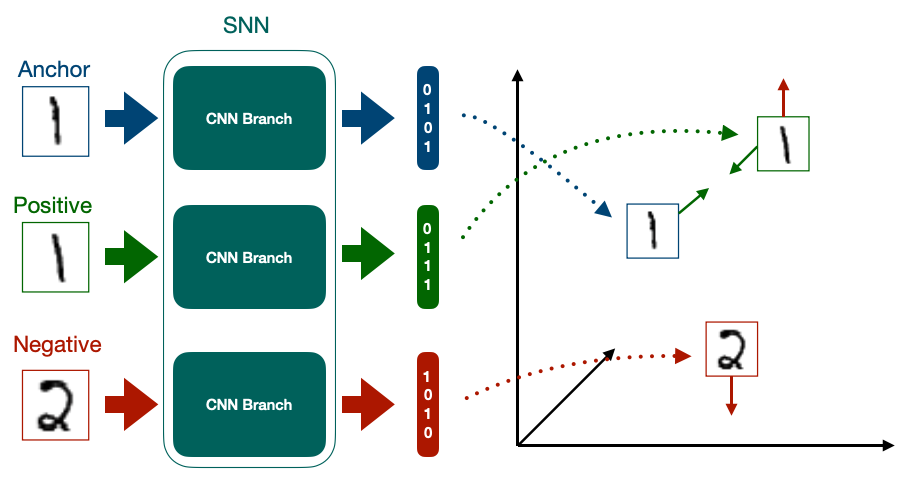

# Imports

In [2]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [7]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [9]:
row = df.iloc[14]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative) 

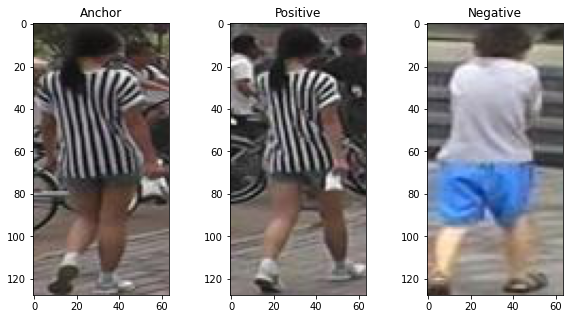

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [11]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset 

In [12]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative) 

        A_img = torch.from_numpy(A_img).permute(2, 0, 1)/ 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1)/ 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1)/ 255.0

        return A_img, P_img, N_img

In [13]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size if validset: {len(validset)}")


Size of trainset: 3200
Size if validset: 800


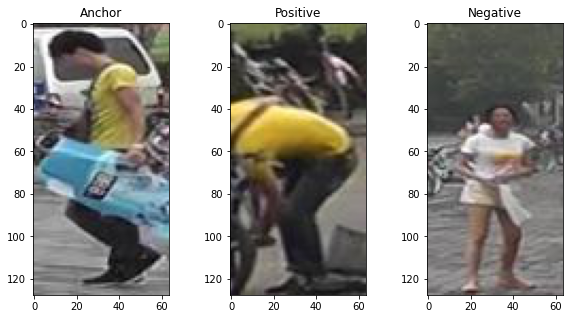

In [14]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [15]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [16]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [17]:
for A, P, N in trainloader:
    break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [18]:
class APN_Model(nn.Module):

    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings


In [19]:
model = APN_Model()
model.to(DEVICE) 

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

# Create Train and Eval function

In [20]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train() # ON Dropout
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    return total_loss / len(dataloader)


In [21]:
def eval_fn(model, dataloader, criterion):

    model.eval() # ON Dropout
    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()
        
    return total_loss / len(dataloader)


In [22]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [23]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCESS")

    print(f"EPOCHS: {i + 1} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 1 train_loss: 0.6364211571216584 valid_loss: 0.6795957159996032


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 2 train_loss: 0.3281471759080887 valid_loss: 0.35378644943237303


100%|██████████| 25/25 [00:02<00:00,  8.40it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 3 train_loss: 0.18738886035978794 valid_loss: 0.3178035491704941


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 4 train_loss: 0.11304512456059455 valid_loss: 0.1451556357741356


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


EPOCHS: 5 train_loss: 0.08213538974523545 valid_loss: 0.18406448006629944


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


EPOCHS: 6 train_loss: 0.07204972691833973 valid_loss: 0.15048762738704682


100%|██████████| 25/25 [00:04<00:00,  6.13it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 7 train_loss: 0.06874616518616676 valid_loss: 0.12040655910968781


100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


EPOCHS: 8 train_loss: 0.0465740105509758 valid_loss: 0.1924542987346649


100%|██████████| 25/25 [00:02<00:00,  8.75it/s]


EPOCHS: 9 train_loss: 0.04848142683506012 valid_loss: 0.13808942437171937


100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


EPOCHS: 10 train_loss: 0.04437731549143791 valid_loss: 0.1518288719654083


100%|██████████| 25/25 [00:02<00:00,  8.64it/s]


EPOCHS: 11 train_loss: 0.037823435813188554 valid_loss: 0.1353469556570053


100%|██████████| 25/25 [00:02<00:00,  8.48it/s]


EPOCHS: 12 train_loss: 0.05602147050201893 valid_loss: 0.1534628987312317


100%|██████████| 25/25 [00:02<00:00, 10.46it/s]


SAVED_WEIGHTS_SUCESS
EPOCHS: 13 train_loss: 0.04450021632015705 valid_loss: 0.09036360442638397


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


EPOCHS: 14 train_loss: 0.026465555876493452 valid_loss: 0.1470784616470337


100%|██████████| 25/25 [00:03<00:00,  8.29it/s]

EPOCHS: 15 train_loss: 0.018569536730647086 valid_loss: 0.15235005915164948


# Get Anchor Embeddings

In [27]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1)/ 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0)) #(c,h,w) -> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        encodings = np.array(encodings) 
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1) 
    
    return df_enc

In [28]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:56<00:00, 71.00it/s]


In [29]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,1.172506,0.006388,0.124889,-0.081585,1.577546,-0.192785,-0.401143,-1.637140,0.725932,...,0.277528,-0.149298,-0.187408,0.644736,0.009452,-0.560675,0.458671,-0.223840,0.270776,-0.591285
1,1420_c3s3_061978_03.jpg,0.799379,-0.363655,0.115483,-0.804142,1.779794,-0.081021,-0.959092,-1.055992,0.933641,...,0.210486,0.143820,-0.157229,0.537659,0.201709,-1.025589,0.482040,-0.326772,0.139680,-0.861175
2,1420_c5s3_062565_05.jpg,1.109075,-0.044892,0.081045,-0.454344,1.361065,-0.183977,-0.620327,-1.203564,0.809726,...,0.338735,0.118410,-0.133290,0.604646,-0.121198,-0.888431,0.507894,-0.531884,0.099383,-0.797320
3,1420_c6s3_085592_04.jpg,0.817055,0.170634,0.197928,0.235464,0.728171,-0.396562,0.007713,-1.710428,0.210343,...,0.643218,-0.521013,-0.093482,0.614934,0.044363,0.229029,0.078048,-0.248529,0.352154,-0.231407
4,0663_c5s3_085987_03.jpg,0.068322,0.557344,0.153051,0.779450,-1.194687,0.100506,0.470699,-0.525092,-0.390021,...,0.390492,-0.183330,-0.278227,-0.411499,-0.238611,0.778602,-0.318431,-0.148044,-0.256874,0.243454


# Inference

In [30]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [44]:
idx = 90
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name 

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()

# Get encoding of an image
with torch.no_grad():
    img = img.to(DEVICE)

    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [45]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [46]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i + 1, :])
    distance = np.append(distance, dist)


In [47]:
closest_idx = np.argsort(distance)


/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


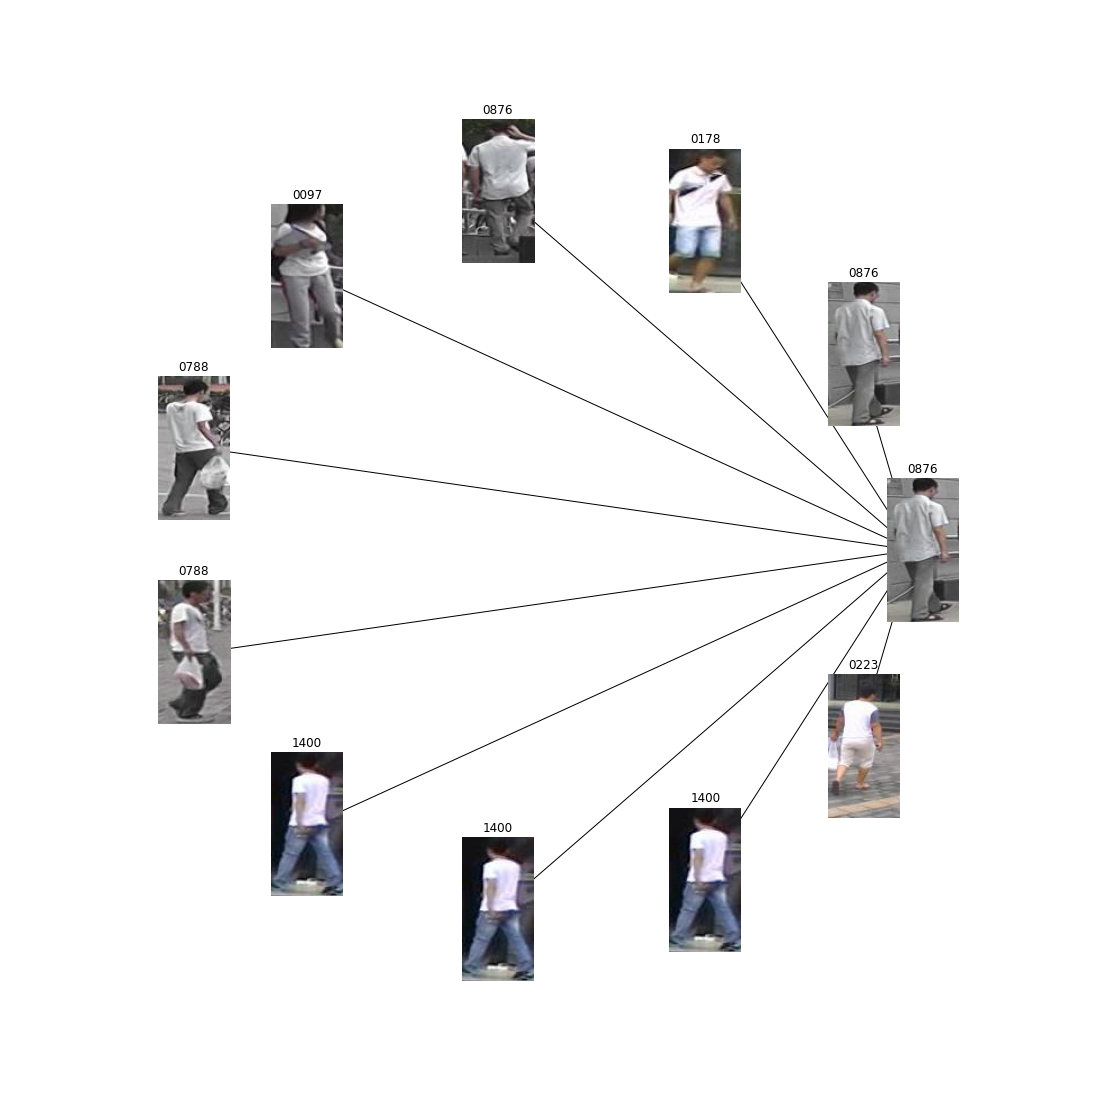

In [48]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);